# Monte Carlo Default Simulation

We aim to estimate the expected loss up to time T:

$$E[L_T] = E\left[\sum_{i=1}^{N} \ell_i \cdot 1\{T_i \leq T\}\right]$$

Where:

- $\ell_i$ represents the loss amount from default $i$
- $T_i$ represents the default time for firm $i$
- $1\{T_i \leq T\}$ is the indicator function for defaults occurring before time $T$

## Model Components

### Firm Intensity Process
Each firm's default intensity is modeled as:

$$\lambda_t^i = X_i + \sum_{j=1}^{J} w_{ij} Y_t^j$$

Where:
- $X_i$ is the idiosyncratic component for firm $i$
- $Y_t^j$ is the sectoral intensity component
- $w_{ij}$ are loading factors representing sensitivity to sectoral factors

### Sectoral Intensity 

**We assume orthogonal sectors.**

$$dY_t^j = \kappa_j(\theta_j - Y_t^j)dt + \sigma_{j}\sqrt{Y_t^j}dW_t^j + \sum_{i=1}^{N}\delta_{ij}dL_t^i$$

Where:
- $\kappa_j$ is the mean reversion speed
- $\theta_j$ is the long-term mean level
- $\sigma_{j}$ are volatility parameters
- $W_t^j$ are standard Brownian motions
- $\delta_{ij}$ are contagion coefficients
- $L_t$ is the loss process 


## In this notebook, we shall aim to experiment with various parameters corresponding to various scenarios, and study the resulting loss distributions and Expected Shortfall and other metrics.

We simulate default times using the Algorithm 3.2 from Gisescke, Kim, Zhu's 2011 paper "Monte Carlo Algorithms for Default Timing Problems"

In [4]:
import numpy as np
import scipy
from scipy.stats import ncx2
from scipy.special import hyp1f1
from scipy.optimize import brentq
from math import exp
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import kurtosis

In [5]:
def lambda_max_generator(epsilon, y, theta, sigma, kappa, max_attempts=5, tol=1e-8):
    """
    Compute H^*_epsilon such that P_y(sigma_H < tau) = G_y(H; H) <= epsilon.
    This function implements Equation (11) using the closed-form in Equation (19).
    """

    def G_y(H):
        a = H / kappa  # Now using H as the Laplace exponent (since tau ~ Exp(H))
        b = 2 * kappa * theta / sigma**2
        z_y = 2 * kappa * y / sigma**2
        z_H = 2 * kappa * H / sigma**2
        num = hyp1f1(a, b, z_y)
        denom = hyp1f1(a, b, z_H)
        return num / denom  # This is G_y(H; H) = E[e^{-H * sigma_H}]

    def root_function(H):
        return G_y(H) - epsilon

    # Bracketing interval
    H_min = y + 1e-8
    H_max = y + 10.0

    # Expand H_max until G_y(H_max) < epsilon
    for _ in range(max_attempts):
        try:
          H_star = scipy.optimize.toms748(root_function, H_min, H_max, xtol=tol)
          
          if root_function(H_star)<=0:
            
            return H_star
          
          else:
          
            while root_function(H_star)>0:
              H_star = H_star + 1e-2
          
            return H_star
          
        except Exception:
            pass
        
        H_max += 5.0

    # Fallback: scan manually to find conservative H
    print("[Warning] brentq failed to converge. Using fallback grid search.")
    H_vals = np.linspace(H_min, H_max + 50, 1000)
    for H in H_vals:
        if G_y(H) <= epsilon:
            return H

    raise RuntimeError("Unable to find H^*_epsilon. Try expanding search space.")


In [6]:
def cir_transition_sample_per_sector(y_vec, tau, kappa_vec, theta_vec, sigma_vec, rng):
    """
    y_vec, kappa_vec, theta_vec, sigma_vec are arrays of length J (sectors).
    Returns xi_vec: sampled Y_{t+tau} per sector (length J).
    """
    if tau <= 0:
        return y_vec.copy()
    
    one_minus = -np.expm1(-kappa_vec * tau)  # = 1 - exp(-kappa*tau)
    # avoid zeros
    one_minus = np.where(one_minus <= 0, 1e-16, one_minus)
    
    c = (sigma_vec * sigma_vec * one_minus) / (4.0 * kappa_vec)
    d = 4.0 * kappa_vec * theta_vec / (sigma_vec * sigma_vec)
    
    # noncentrality parameters
    nc = (4.0 * kappa_vec * np.exp(-kappa_vec * tau) * y_vec) / (sigma_vec * sigma_vec * one_minus)
    
    # guard
    d = np.maximum(d, 1e-12)
    nc = np.maximum(nc, 0.0)
    
    # sample per sector (simple looping works fine since J would be typically small)
    xi = np.empty_like(y_vec, dtype=float)

    for j in range(len(y_vec)):
    
        # If df or nc are extreme, ncx2.rvs might throw an error
        try:
            Z = ncx2.rvs(df=d[j], nc=nc[j], random_state=rng)
    
        except Exception:
            Z = ncx2.rvs(df=max(d[j],1e-6), nc=0.0, random_state=rng) + nc[j]
    
        xi[j] = c[j] * Z
    
    xi = np.maximum(xi, 0.0)
    
    return xi


In [ ]:
def simulate_sector_cir_model(kappa, theta, sigma, T, delta, W, eps, lambda_benchmark,
                              Nfirms, idiosyncratic_factor, rng=None):
    """
    Simulate defaults up to horizon T for N firms with J sectors using Algo 3.2.

    Inputs:
      - kappa, theta, sigma: arrays length J (sector params)
      - T: horizon (scalar)
      - delta: N x J contagion matrix (per-firm impact on sectors on default) OR J-length vector (same for all firms)
      - W: N x J matrix of loadings w_{i,j}
      - eps: target small probability for H*
      - lambda_benchmark: length-J array of precomputed H* per-sector (benchmark caps)
      - Nfirms: number of firms (int)
      - idiosyncratic_factor: length-N array X_i
      - rng: numpy.random.Generator (optional)

    Returns:
      events (list of default times),
      marks (list of loss marks),
      defaulter_idio_factor (list),
      sector_contributions (list of J-vectors for each default)
    """
    import warnings

    if rng is None:
        rng = np.random.default_rng()

    # ensure shapes
    J = len(theta)
    assert W.shape == (Nfirms, J)
    idiosyncratic_factor = np.asarray(idiosyncratic_factor).reshape(Nfirms,)
    lambda_benchmark = np.asarray(lambda_benchmark).reshape(J,)

    # treat delta: if N x J passed, keep. if J-length, broadcast.
    delta = np.asarray(delta)
    if delta.ndim == 1:
        delta = np.tile(delta.reshape(1, J), (Nfirms, 1))
    assert delta.shape == (Nfirms, J)

    # init
    t = 0.0
    Y_t = theta.copy().astype(float)   # sectoral intensities (J-vector), initialised at theta
    events = []
    marks = []
    defaulter_idio_factor = []
    sector_contributions = []
    alive = np.arange(Nfirms, dtype=int)

    # precompute some arrays for speed
    kappa = np.asarray(kappa, dtype=float)
    sigma = np.asarray(sigma, dtype=float)
    theta = np.asarray(theta, dtype=float)

    # event loop
    while (t < T) and (alive.size > 0):

        lambda_max = np.maximum(Y_t, lambda_benchmark)  # J-vector
        # Hepsilon = sum_i [ X_i + w_i · lambda_max ] over alive firms
        
        # We can compute per-firm value and sum
        per_firm_sys = W[alive].dot(lambda_max)   # length alive.size
        per_firm_idio = idiosyncratic_factor[alive]
        Hepsilon = per_firm_sys.sum() + per_firm_idio.sum()

        if Hepsilon <= 0:
            break

        # sample a candidate waiting time
        tau = rng.exponential(1.0 / Hepsilon)
        t_candidate = t + tau
        if t_candidate >= T:
            break

        # sample sectoral Y at t_candidate conditional on no defaults in the waiting time
        Y_proposed = cir_transition_sample_per_sector(Y_t, tau, kappa, theta, sigma, rng)

        # compute proposed per-firm intensities (scalar values) using Y_proposed
        per_firm_sys_prop = W[alive].dot(Y_proposed)
        per_firm_total_prop = per_firm_sys_prop + per_firm_idio
        lambda_proposed_total = per_firm_total_prop.sum()

        # acceptance probability: Xi / Hepsilon where Xi = lambda_proposed_total
        accept_prob = min(lambda_proposed_total / Hepsilon, 1.0)
        if rng.random() < accept_prob:
            # accept a default at t_candidate
            t = t_candidate
            events.append(t)

            # choose which alive firm defaulted
            probs = per_firm_total_prop / lambda_proposed_total
            probs = np.maximum(probs, 0.0)
            probs = probs / probs.sum()
            selected_local_idx = rng.choice(len(alive), p=probs)
            selected_firm = int(alive[selected_local_idx])

            # record idiosyncratic factor
            defaulter_idio_factor.append(float(idiosyncratic_factor[selected_firm]))

            sector_contributions.append(W[selected_firm].copy())

            # mark (loss) from contract exposure
            contract = loan_contracts[selected_firm]
            exposure = exposure_at_time(contract, t)
            if exposure < 0:
                warnings.warn("Exposure computed negative; clamping to zero.")
                exposure = max(exposure, 0.0)
            if t >= float(contract["T"]) and exposure > 0:
                warnings.warn("Exposure positive after maturity; forcing to zero.")
                exposure = 0.0

            LGD = float(contract["LGD"])
            mark = LGD * exposure
            if mark < 0:
                warnings.warn("Loss mark negative; clamping to zero.")
                mark = max(mark, 0.0)
            marks.append(mark)

            # apply contagion: scale by remaining exposure fraction
            P_orig = float(contract["P"])
            exposure_fraction = exposure / P_orig if P_orig > 0 else 0.0
            if P_orig <= 0:
                warnings.warn("Original principal non-positive; contagion set to zero.")
            Y_t = Y_proposed + delta[selected_firm] * exposure_fraction

            # remove defaulted firm from alive set
            alive = np.delete(alive, selected_local_idx)

        else:
            # reject, ie no default: advance time and set Y_t = Y_proposed
            t = t_candidate
            Y_t = Y_proposed

    return (np.array(events), np.array(marks),
            np.array(defaulter_idio_factor), np.array(sector_contributions))

In [8]:
from scipy.interpolate import interp1d

def loss_distribution_plot(Payoff_T,index):
  # Get histogram data (without plotting)
  counts, bin_edges = np.histogram(Payoff_T, bins=10, density=True)

  # Get bin centers
  bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

  # Interpolation function
  f_interp = interp1d(bin_centers, counts, kind='cubic', fill_value="extrapolate")

  # New x-values for smooth curve
  x_smooth = np.linspace(bin_centers.min(), bin_centers.max(), 500)
  y_smooth = f_interp(x_smooth)

  # Plot histogram and interpolated curve
  plt.hist(Payoff_T, bins=100, density=True, label='Histogram_'+str(index),alpha = 0.4)
  plt.plot(x_smooth, y_smooth, label='Loss Distribution Case_'+str(index))
  plt.xlabel('Loss')
  plt.ylabel('Density')
  # plt.legend()


In [47]:
def expected_shortfall(losses, alpha=0.95):
    var_alpha = np.quantile(losses, alpha)
    tail_losses = losses[losses >= var_alpha]
    return tail_losses.mean()

def compute_metrics(losses, alpha=0.95):
    return {
        "Mean": np.mean(losses),
        "Std": np.std(losses),
        "VaR": np.quantile(losses, alpha),
        "ES": expected_shortfall(losses, alpha),
        "ExcessKurtosis": kurtosis(losses)
    }


In [10]:
def run_simulation(J, Nfirms, params, T, num_trials):

    eps = 1e-5
    losses = np.zeros(num_trials)
    for i in range(num_trials):
        events, marks, _, _ = simulate_sector_cir_model(
            params['kappa'], params['theta'], params['sigma'],
            T, params['delta'], params['W'], eps, params['lambda_benchmark'],
            Nfirms, params['idio_factor']
        )
        losses[i] = np.sum(marks)
    return losses

In [11]:
rng = np.random.default_rng(1234)
J = 2
Nfirms = 100
theta_sector = rng.uniform(0.01, 0.051, J)
kappa_sector = rng.uniform(0.1, 0.5, J)
sigma_sector = rng.uniform(0.04, 0.049, J)

if ((2*kappa_sector*theta_sector)/(sigma_sector**2)).all()>=1:
    print("Feller condition satisfied.")

# idiosyncratic factors
X_idio = np.ones(Nfirms) * 0.07

# W loadings: create two groups concentrated in sector 0 or sector 1
W1 = rng.dirichlet([5000, 1], size=Nfirms//2)
W2 = rng.dirichlet([1, 5000], size=Nfirms//2)
W = np.vstack((W1, W2))
rng.shuffle(W)

# for simplicity use delta = W (each firm contagion proportional to its loadings)
delta = W.copy()

Feller condition satisfied.


In [12]:
params = {
    'kappa': kappa_sector,
    'theta': theta_sector,
    'sigma': sigma_sector,
    'delta': delta,
    'lambda_benchmark': np.array([lambda_max_generator(1e-4, theta_sector[j], theta_sector[j], sigma_sector[j], kappa_sector[j]) for j in range(J)]),
    'idio_factor': X_idio,
    'W': W
}

In [13]:
params

{'kappa': array([0.46929849, 0.20467697]),
 'theta': array([0.05004469, 0.02558803]),
 'sigma': array([0.04287187, 0.04106282]),
 'delta': array([[5.04026429e-07, 9.99999496e-01],
        [9.99397439e-01, 6.02561340e-04],
        [9.99827468e-01, 1.72531806e-04],
        [8.78418253e-05, 9.99912158e-01],
        [2.00059602e-04, 9.99799940e-01],
        [1.75308072e-04, 9.99824692e-01],
        [4.87530454e-05, 9.99951247e-01],
        [9.99902693e-01, 9.73070683e-05],
        [9.99883871e-01, 1.16129391e-04],
        [3.53784365e-04, 9.99646216e-01],
        [9.99693845e-01, 3.06155329e-04],
        [9.99847198e-01, 1.52802160e-04],
        [9.99998046e-01, 1.95430254e-06],
        [7.90319456e-05, 9.99920968e-01],
        [9.99972972e-01, 2.70283007e-05],
        [9.99933927e-01, 6.60732707e-05],
        [9.99743541e-01, 2.56459262e-04],
        [9.99693696e-01, 3.06303654e-04],
        [4.58927688e-05, 9.99954107e-01],
        [9.99958935e-01, 4.10649851e-05],
        [9.99786717e-0

In [14]:
print(params['W'][0:10])

[[5.04026429e-07 9.99999496e-01]
 [9.99397439e-01 6.02561340e-04]
 [9.99827468e-01 1.72531806e-04]
 [8.78418253e-05 9.99912158e-01]
 [2.00059602e-04 9.99799940e-01]
 [1.75308072e-04 9.99824692e-01]
 [4.87530454e-05 9.99951247e-01]
 [9.99902693e-01 9.73070683e-05]
 [9.99883871e-01 1.16129391e-04]
 [3.53784365e-04 9.99646216e-01]]


In [15]:
params['lambda_benchmark']

array([0.10960989, 0.09643302])

In [16]:
# run one simulation
eps = 1e-5
events, marks, defaulter_idio_factor, sector_contribs = simulate_sector_cir_model(
    kappa=params['kappa'], theta=params['theta'], sigma=params['sigma'], T=0.5,
    delta=params['delta'], W=params['W'], eps=eps, lambda_benchmark=params['lambda_benchmark'],
    Nfirms=Nfirms, idiosyncratic_factor=params['idio_factor'], rng=rng
)

print("Events:", len(events), "Total loss:", marks.sum())


Events: 100 Total loss: 50.84073188660857


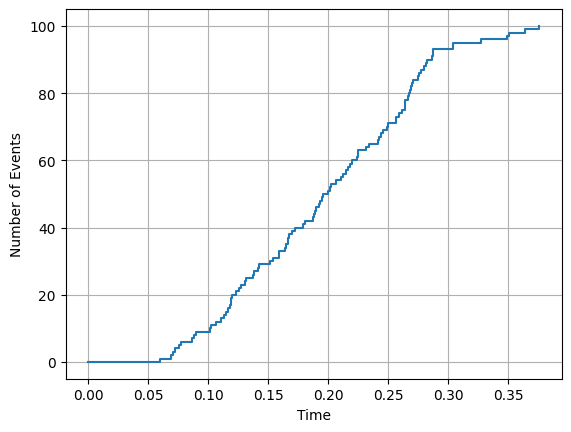

In [17]:
event_counts = np.arange(1, len(events) + 1)
arrival_times = np.insert(events, 0, 0.0)
event_counts = np.insert(event_counts, 0, 0)
plt.step(arrival_times, event_counts, where='post')
plt.xlabel("Time")
plt.ylabel("Number of Events")
plt.grid(True)
plt.show()

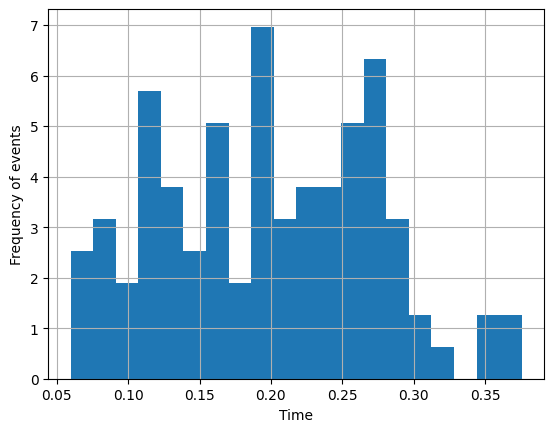

In [18]:
plt.hist(events, bins=20, density=True)
plt.xlabel("Time")
plt.ylabel("Frequency of events")
plt.grid(True)

In [19]:
resutl = {}
resutl['events'] = events
resutl['marks'] = marks
resutl['Sector 1'] = sector_contribs[:,0]
resutl['Sector 2'] = sector_contribs[:,1]
df_Result = pd.DataFrame(resutl)
df_Result

,events,marks,Sector 1,Sector 2
0,0.059784,0.915619,0.999898,0.000102
1,0.068711,0.804312,0.999972,0.000028
2,0.070604,0.187788,0.999683,0.000317
3,0.072302,0.640165,0.999874,0.000126
4,0.075902,0.858905,0.999956,0.000044
...,...,...,...,...
95,0.326846,0.805250,0.000175,0.999825
96,0.349133,0.188576,0.999862,0.000138
97,0.350679,0.179107,0.000006,0.999994
98,0.363607,0.465710,0.000088,0.999912


In [20]:
losses = run_simulation(J, Nfirms, params, T=0.5, num_trials=1000)

In [21]:
compute_metrics(losses, alpha=0.95)

{'Mean': np.float64(38.0766288761669),
 'Std': np.float64(13.076574653489185),
 'VaR': np.float64(53.40012945861549),
 'ES': np.float64(54.57408873005913),
 'ExcessKurtosis': np.float64(-3.135842464020281)}

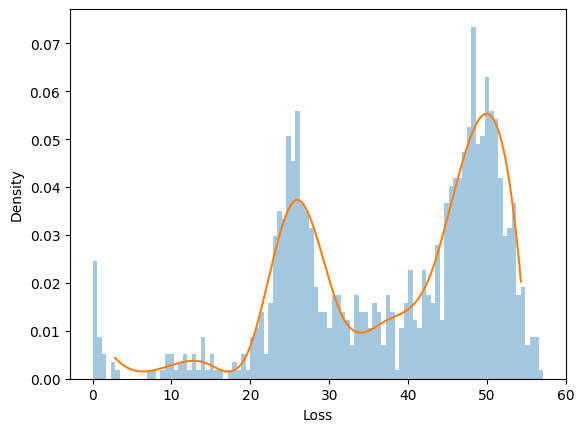

In [22]:
loss_distribution_plot(losses,1)

In [23]:
def generate_portfolio_weights(N, J, composition_type, concentration_params=None, rng=None):
    """
    Generate portfolio weight matrix W for different compositions and scenarios.
    
    Parameters:
    -----------
    N : int
        Number of firms
    J : int  
        Number of sectors
    composition_type : str
        'homogeneous', 'concentrated', 'block_concentrated', 'random'
    concentration_params : dict, optional
        Parameters for controlling concentration levels
        
    Returns:
    --------
    W : ndarray of shape (N, J)
        Weight matrix where W[i,j] is firm i's loading on sector j
        Rowwise normalised
    """
    if rng is None:
        rng = np.random.default_rng()
    
    if concentration_params is None:
        concentration_params = {}
    
    if composition_type == 'homogeneous':
        return _generate_homogeneous_weights(N, J, concentration_params, rng)
    
    elif composition_type == 'concentrated':
        return _generate_concentrated_weights(N, J, concentration_params, rng)
    
    elif composition_type == 'block_concentrated':
        return _generate_block_concentrated_weights(N, J, concentration_params, rng)
    
    elif composition_type == 'random':
        return _generate_random_weights(N, J, concentration_params, rng)
    
    else:
        raise ValueError(f"Unknown composition_type: {composition_type}")


def _generate_homogeneous_weights(N, J, params, rng):
    """Roughly equal weights across all sectors for all firms."""
    noise_level = params.get('noise_level', 0.1)  # small random variations
    
    base_weights = np.ones((N, J)) / J
    noise = rng.normal(0, noise_level, (N, J))
    W = base_weights + noise
    
    W = np.maximum(W, 1e-6)
    W = W / W.sum(axis=1, keepdims=True)
    
    return W


def _generate_concentrated_weights(N, J, params, rng):
    """Each firm heavily weighted in one dominant sector."""
    concentration_alpha = params.get('concentration_alpha', 100.0)  # higher = more concentrated
    background_alpha = params.get('background_alpha', 1.0)
    
    W = np.zeros((N, J))
    
    for i in range(N):
        # Randomly pick dominant sector for this firm
        dominant_sector = rng.integers(0, J)
        
        alphas = np.full(J, background_alpha)
        alphas[dominant_sector] = concentration_alpha
        
        W[i] = rng.dirichlet(alphas)
    
    return W


def _generate_block_concentrated_weights(N, J, params, rng):
    """Firms grouped into blocks, each block concentrated in specific sectors."""
    concentration_alpha = params.get('concentration_alpha', 1000.0)
    background_alpha = params.get('background_alpha', 1.0)
    firms_per_block = params.get('firms_per_block', N // J)
    
    W = np.zeros((N, J))
    
    # Create blocks
    for block_idx in range(J):
        start_firm = block_idx * firms_per_block
        end_firm = min((block_idx + 1) * firms_per_block, N)
        
        if start_firm >= N:
            break
    
        alphas = np.full(J, background_alpha)
        alphas[block_idx] = concentration_alpha
        
        for i in range(start_firm, end_firm):
            W[i] = rng.dirichlet(alphas)
    
    # Handle remaining firms if N not divisible by J
    remaining_start = (J * firms_per_block)
    if remaining_start < N:
        # Distribute remaining firms randomly across sectors
        for i in range(remaining_start, N):
            dominant_sector = rng.integers(0, J)
            alphas = np.full(J, background_alpha)
            alphas[dominant_sector] = concentration_alpha
            W[i] = rng.dirichlet(alphas)
    
    return W


def _generate_random_weights(N, J, params, rng):
    """Completely random weights using symmetric Dirichlet."""
    alpha = params.get('alpha', 1.0)  # alpha=1 gives uniform over simplex
    
    W = np.zeros((N, J))
    for i in range(N):
        W[i] = rng.dirichlet(np.full(J, alpha))
    
    return W


def generate_scenario_matrix(N_list, J_list, composition_types, rng=None):
    """
    Generate weight matrices for all combinations of N, J, and composition types.
    
    Parameters:
    -----------
    N_list : list of int
        Portfolio sizes to test
    J_list : list of int  
        Number of sectors to test
    composition_types : list of str
        Composition types to test
    rng : numpy.random.Generator, optional
        
    Returns:
    --------
    scenarios : dict
        Nested dict with structure scenarios[N][J][composition_type] = W_matrix
    """
    if rng is None:
        rng = np.random.default_rng()
    
    scenarios = {}
    
    for N in N_list:
        scenarios[N] = {}
        for J in J_list:
            scenarios[N][J] = {}
            for comp_type in composition_types:

                if comp_type == 'concentrated':
                    concentration_params = {
                        'concentration_alpha': max(50.0, N / 10),  # scale with portfolio size
                        'background_alpha': 1.0
                    }
                elif comp_type == 'block_concentrated':
                    concentration_params = {
                        'concentration_alpha': max(100.0, N / 5),
                        'background_alpha': 1.0,
                        'firms_per_block': max(N // J, 10)  # ensure reasonable block sizes
                    }
                elif comp_type == 'homogeneous':
                    concentration_params = {
                        'noise_level': 0.05  # small noise for homogeneous
                    }
                else:  # random
                    concentration_params = {'alpha': 1.0}
                
                W = generate_portfolio_weights(N, J, comp_type, concentration_params, rng)
                scenarios[N][J][comp_type] = W
                
    return scenarios

## Baseline params


In [24]:
rng = np.random.default_rng(42)

Nfirms_baseline = 100
J_baseline = 3
composition_type = 'homogeneous'
W_baseline = generate_portfolio_weights(
    N=Nfirms_baseline,
    J=J_baseline,
    composition_type=composition_type,
    concentration_params={'concentration_alpha': 100.0, 'background_alpha': 1.0},
    rng=rng
)

theta_baseline = rng.uniform(0.02, 0.05, J_baseline)
kappa_baseline = rng.uniform(0.1, 0.3, J_baseline)
sigma_baseline = rng.uniform(0.03, 0.05, J_baseline)

feller = (2 * kappa_baseline * theta_baseline) / (sigma_baseline**2)
print("Feller condition (should be >=1):", feller)

X_idio_baseline = np.ones(Nfirms_baseline) * 0.05

# keep delta = W for now in baseline
delta_baseline = W_baseline.copy()

lambda_benchmark_baseline = np.array([
    lambda_max_generator(1e-4, theta_baseline[j], theta_baseline[j],
                         sigma_baseline[j], kappa_baseline[j])
    for j in range(J_baseline)
])

params_baseline = {
    'kappa': kappa_baseline,
    'theta': theta_baseline,
    'sigma': sigma_baseline,
    'delta': delta_baseline,
    'lambda_benchmark': lambda_benchmark_baseline,
    'idio_factor': X_idio_baseline,
    'W': W_baseline
}


Feller condition (should be >=1): [6.91392178 4.54996102 6.29387562]


In [25]:
assert params_baseline['W'].shape == (Nfirms_baseline, J_baseline)

In [26]:
params_baseline['theta']

array([0.0269771 , 0.03102535, 0.03099177])

In [27]:
events, marks, defaulter_idio_factor, sector_contribs = simulate_sector_cir_model(params_baseline['kappa'], params_baseline['theta'], params_baseline['sigma'], 
                          0.5, params_baseline['W'], params_baseline['W'], 1e-5, 
                          params_baseline['lambda_benchmark'], 
                          Nfirms_baseline, params_baseline['idio_factor'], rng)

print("Events:", len(events), "Total loss:", marks.sum())

Events: 99 Total loss: 48.880949030727365


In [28]:
losses_baselines = run_simulation(J, Nfirms, params, T=0.5, num_trials=1000)

In [29]:
compute_metrics(losses_baselines, alpha=0.95)

{'Mean': np.float64(38.51234644768974),
 'Std': np.float64(13.182545685724103),
 'VaR': np.float64(53.641437134166154),
 'ES': np.float64(54.75467924499645),
 'ExcessKurtosis': np.float64(-3.165912576470788)}

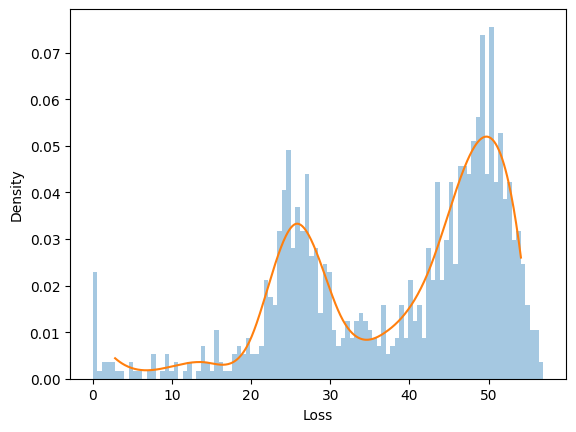

In [30]:
loss_distribution_plot(losses_baselines,'baseline')

In [31]:
# sector_sizes = [2, 3, 5, 10]
sector_sizes = [2]
portfolio_sizes = [100, 1000, 10000]
portfolio_compositions = ['homogeneous', 'concentrated']
parameter_ranges = {
    # 'kappa': [(0.01,0.1), (0.1,0.25), (0.25,0.6), (0.5,1.0)],
    'kappa': [(0.01,0.1), (0.5,1.0)],
    'sigma': [(0.01,0.03), (0.06,0.12)],
    'theta': [(0.005,0.02), (0.05,0.15)]
}
results = []

In [32]:
from itertools import product
from joblib import Parallel, delayed
import numpy as np
import pandas as pd

def run_single_simulation(J, N, composition, kappa_range, sigma_range, theta_range):
    rng = np.random.default_rng()
    W = generate_portfolio_weights(N, J, composition, rng=rng)

    kappa = np.random.uniform(*kappa_range, J)
    sigma = np.random.uniform(*sigma_range, J)
    theta = np.random.uniform(*theta_range, J)

    # Stability condition
    if not np.all((2 * kappa * theta) / (sigma**2) >= 1):
        return None

    delta = W.copy()
    lambda_benchmark = np.array([
        lambda_max_generator(1e-4, theta[j], theta[j], sigma[j], kappa[j]) for j in range(J)
    ])

    params = {
        'kappa': kappa,
        'theta': theta,
        'sigma': sigma,
        'delta': delta,
        'lambda_benchmark': lambda_benchmark,
        'idio_factor': np.ones(N) * 0.05,
        'W': W
    }

    losses = run_simulation(J, N, params, T=0.5, num_trials=100)

    return {
        'J': J,
        'N': N,
        'composition': composition,
        'kappa': kappa,
        'sigma': sigma,
        'theta': theta,
        'losses': losses
    }


raw_results = Parallel(n_jobs=-1)(
    delayed(run_single_simulation)(J, N, composition, kappa_range, sigma_range, theta_range)
    for J, N, composition, kappa_range, sigma_range, theta_range in product(
        sector_sizes,
        portfolio_sizes,
        portfolio_compositions,
        parameter_ranges['kappa'],
        parameter_ranges['sigma'],
        parameter_ranges['theta']
    )
)

# Remove failed/None runs
results = [r for r in raw_results if r is not None]


KeyboardInterrupt: 

In [39]:
# Compute metrics for each scenario
for result in results:
    losses = result['losses']
    metrics = compute_metrics(losses, alpha=0.95)
    result['metrics'] = metrics

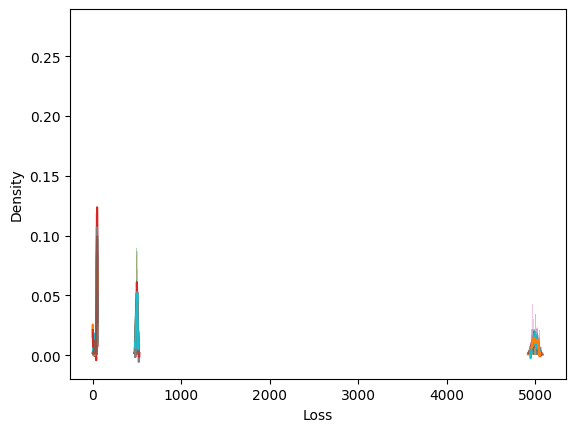

In [40]:
# Plot loss distributions for each scenario
for i, result in enumerate(results):
    losses = result['losses']
    loss_distribution_plot(losses, index=i)

In [ ]:
df_results = pd.DataFrame([{
    'J': result['J'],
    'N': result['N'],
    'composition': result['composition'],
    'kappa': result['kappa'].tolist(),
    'sigma': result['sigma'].tolist(),
    'theta': result['theta'].tolist(),
    'Mean': result['metrics']['Mean'],
    'Std': result['metrics']['Std'],
    'VaR': result['metrics']['VaR'],
    'ES': result['metrics']['ES'],
    'ExcessKurtosis': result['metrics']['ExcessKurtosis']
} for result in results])    
df_results

,J,N,composition,kappa,sigma,theta,Mean,Std,VaR,ES,ExcessKurtosis
0,2,100,homogeneous,"[0.07732111500404994, 0.057952613450506354]","[0.01028537964977801, 0.028162657747377615]","[0.018823075471097045, 0.01215002816546554]",38.630988,17.999194,52.694509,54.470816,-3.026748
1,2,100,homogeneous,"[0.08135133247043813, 0.05363736944941725]","[0.013795954786247662, 0.018864360154044815]","[0.13403350850528253, 0.09601949090783374]",48.942744,4.672540,54.332962,55.660680,0.559716
2,2,100,homogeneous,"[0.08609997630775337, 0.057478589044246145]","[0.07517658582173008, 0.10440002255552605]","[0.11761453690910091, 0.0994423233863569]",48.357985,6.513045,55.976896,56.784626,9.427895
3,2,100,homogeneous,"[0.5083659515515395, 0.5171596976450856]","[0.013113371129784375, 0.014664719398771375]","[0.016010620275390176, 0.014990517118251879]",38.817894,17.498952,52.686444,54.643930,-2.641906
4,2,100,homogeneous,"[0.9890417527561153, 0.8635688242186932]","[0.020786475797420604, 0.022828485224943858]","[0.11537792004212062, 0.07803398847904039]",46.502424,9.865333,55.462177,57.084610,5.086210
5,2,100,homogeneous,"[0.661514148749079, 0.5705657179247028]","[0.07465271899240443, 0.08249679872440968]","[0.015507267235636142, 0.011974711513272554]",37.506533,17.799397,53.353124,54.131026,-3.205712
6,2,100,homogeneous,"[0.9888044386458084, 0.8209834497287575]","[0.06866218010958296, 0.08300909112361668]","[0.1297877149474732, 0.054466822029705354]",48.476966,8.159483,54.629158,55.512004,15.949584
7,2,100,concentrated,"[0.07697323716975263, 0.08167668107819337]","[0.021858009444279437, 0.02034841916598671]","[0.012526592541788865, 0.013605460713642225]",36.233760,17.113806,52.871393,54.969935,-3.561983
8,2,100,concentrated,"[0.06305163105867334, 0.05418206533837046]","[0.015019534670963515, 0.012042678679393787]","[0.130219986627543, 0.1407694677869885]",48.041115,5.538216,55.067557,56.316637,4.167488
9,2,100,concentrated,"[0.7454691103134796, 0.7626199904334432]","[0.026577924091454447, 0.016879805733621387]","[0.009283286258151347, 0.015518183830742478]",34.334936,16.973327,52.581156,53.758279,-3.813095


In [ ]:
len(df_results)

36

Exception ignored in: <function ResourceTracker.__del__ at 0x1088ca340>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.7/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 84, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.7/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 93, in _stop
  File "/opt/homebrew/Cellar/python@3.13/3.13.7/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 118, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1073ae340>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.7/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 84, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.7/Frameworks/Python.framework/Versi

In [33]:
loan_types = ["bullet", "linear", "french"]

loan_contracts = [
    {
        "type": loan_types[i % len(loan_types)],
        "P": 100.0,
        "T": 5.0,
        "N": 20,
        "r": 0.03,
        "LGD": 0.45,
    }
    for i in range(Nfirms)
]

len(loan_contracts)

100

In [57]:
def bullet_exposure(contract, t):
    P = float(contract["P"])
    T = float(contract["T"])
    return P if t < T else 0.0


def linear_exposure(contract, t):
    P = float(contract["P"])
    T = float(contract["T"])
    N = int(contract["N"])
    if N <= 0 or T <= 0:
        return 0.0

    period = T / N
    payments_made = int(np.floor(t / period))
    payments_made = int(np.clip(payments_made, 0, N))
    principal_paid = (payments_made / N) * P
    return max(P - principal_paid, 0.0)


def french_exposure(contract, t):
    P = float(contract["P"])
    T = float(contract["T"])
    N = int(contract["N"])
    r = float(contract["r"])
    if N <= 0 or T <= 0:
        return 0.0

    period = T / N
    payments_made = int(np.floor(t / period))
    payments_made = int(np.clip(payments_made, 0, N))
    periods_remaining = N - payments_made
    if periods_remaining <= 0:
        return 0.0

    if r == 0.0:
        payment = P / N
        return payment * periods_remaining

    annuity_payment = P * r / (1.0 - (1.0 + r) ** (-N))
    pv_remaining = annuity_payment * (1.0 - (1.0 + r) ** (-periods_remaining)) / r
    return pv_remaining


def negative_amortization_exposure(contract, t):
    P = float(contract["P"])
    T = float(contract["T"])
    N = int(contract["N"])
    r = float(contract.get("r", 0.0))
    if N <= 0 or T <= 0:
        return max(P, 0.0)

    period = T / N
    periods_elapsed = int(np.floor(t / period))
    periods_elapsed = int(np.clip(periods_elapsed, 0, N))

    # Borrowing/interest accrues; no principal repayment until maturity
    exposure = P * ((1.0 + r)**(periods_elapsed))

    # After maturity, exposure should drop to zero (handled by caller guard as well)
    return exposure if t < T else 0.0


def exposure_at_time(contract, t):
    loan_type = str(contract["type"]).lower()
    dispatch = {
        "bullet": bullet_exposure,
        "linear": linear_exposure,
        "french": french_exposure,
        "negative_amortisation": negative_amortization_exposure,
    }
    if loan_type not in dispatch:
        raise ValueError(f"Unknown loan type: {loan_type}")
    return dispatch[loan_type](contract, t)


In [ ]:
# Scenario: J=5, N=1000 with linear loan exposures
rng = np.random.default_rng(2026)

J = 3
Nfirms = 1000
T_horizon = 1
composition_type = "concentrated"

W = generate_portfolio_weights(
    N=Nfirms,
    J=J,
    composition_type=composition_type,
    concentration_params={"noise_level": 0.05},
    rng=rng,
)

theta = rng.uniform(0.001,0.051, J)
kappa = rng.uniform(0.1, 0.5, J)
sigma = rng.uniform(0.0, 0.2, J)

feller = (2 * kappa * theta) / (sigma ** 2)
print("Feller condition min (should be >=1):", feller.min())

# contagion proportional to weights
delta = W.copy()

lambda_benchmark = np.array([
    lambda_max_generator(1e-4, theta[j], theta[j], sigma[j], kappa[j])
    for j in range(J)
])

params = {
    "kappa": kappa,
    "theta": theta,
    "sigma": sigma,
    "delta": delta,
    "lambda_benchmark": lambda_benchmark,
    "idio_factor": np.ones(Nfirms) * rng.uniform(0.01, 0.03, Nfirms),
    "W": W,
}

# All firms linear exposure; maturities match simulation horizon
loan_contracts = [
    {
        "type": "linear",
        "P": 100.0,
        "T": T_horizon,
        "N": 20,
        "r": 0.03,
        "LGD": 0.45,
    }
    for _ in range(Nfirms)
]

print("Contracts prepared:", len(loan_contracts))

Feller condition min (should be >=1): 0.1271313777221496
Contracts prepared: 1000


In [52]:
# Run simulation for the J=3, N=1000 scenario
T = T_horizon

# Single-path diagnostic
single_events, single_marks, _, _ = simulate_sector_cir_model(
    params["kappa"], params["theta"], params["sigma"],
    T, params["delta"], params["W"], 1e-5, params["lambda_benchmark"],
    Nfirms, params["idio_factor"], rng=rng,
)
print("Single-path: events=", len(single_events), "total loss=", single_marks.sum())

# Monte Carlo losses
losses = run_simulation(J, Nfirms, params, T=T, num_trials=200)
metrics = compute_metrics(losses, alpha=0.95)
print("Metrics:", metrics)

Single-path: events= 1000 total loss= 503.1023581724892
Metrics: {'Mean': np.float64(500.5139858824882), 'Std': np.float64(9.223420528897726), 'VaR': np.float64(517.363672339981), 'ES': np.float64(520.1355249649492), 'ExcessKurtosis': np.float64(-0.2711698109832481)}


({'Mean': np.float64(498.709040421951),
  'Std': np.float64(9.429988964160009),
  'VaR': np.float64(515.3106075230844),
  'ES': np.float64(518.9706181970744),
  'ExcessKurtosis': np.float64(0.3298582137145516)},
 {'Mean': np.float64(500.35552550649373),
  'Std': np.float64(9.204240154693242),
  'VaR': np.float64(514.2003670229802),
  'ES': np.float64(520.4883136509651),
  'ExcessKurtosis': np.float64(0.5433692510362453)},
 {'Mean': np.float64(500.85143157709246),
  'Std': np.float64(8.961725522266297),
  'VaR': np.float64(515.5257898996848),
  'ES': np.float64(518.549697421528),
  'ExcessKurtosis': np.float64(-0.07752853807684934)})

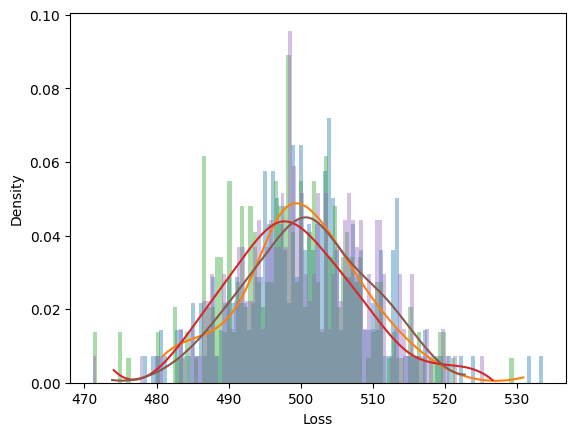

In [54]:
# Monte Carlo loss distribution comparison: linear vs bullet exposures (J=5, N=1000)
num_trials = 250

contract_base = {"P": 100.0, "T": T_horizon, "N": 36, "r": 0.12, "LGD": rng.uniform(0.4, 0.6)}

def make_contracts(contract_type):
    return [{**contract_base, "type": contract_type} for _ in range(Nfirms)]

# Linear exposures
loan_contracts = make_contracts("linear")
losses_linear = run_simulation(J, Nfirms, params, T=T_horizon, num_trials=num_trials)
metrics_linear = compute_metrics(losses_linear, alpha=0.95)

# Bullet exposures
loan_contracts = make_contracts("bullet")
losses_bullet = run_simulation(J, Nfirms, params, T=T_horizon, num_trials=num_trials)
metrics_bullet = compute_metrics(losses_bullet, alpha=0.95)

loan_contracts = make_contracts("french")
losses_french = run_simulation(J, Nfirms, params, T=T_horizon, num_trials=num_trials)
metrics_french = compute_metrics(losses_french, alpha=0.95)

# loss_distribution_plot(losses_baselines,1)
loss_distribution_plot(losses_bullet,1)
loss_distribution_plot(losses_linear,1)
loss_distribution_plot(losses_french,1)

metrics_linear, metrics_bullet, metrics_french


({'Mean': np.float64(499.35418239500024),
  'Std': np.float64(9.37653578999373),
  'VaR': np.float64(516.2543664475235),
  'ES': np.float64(520.1884744745818),
  'ExcessKurtosis': np.float64(0.041949057779574694)},
 {'Mean': np.float64(499.1314928652184),
  'Std': np.float64(8.977169622932127),
  'VaR': np.float64(514.445457865243),
  'ES': np.float64(517.8681959052284),
  'ExcessKurtosis': np.float64(-0.2998236292223866)},
 {'Mean': np.float64(500.7227026464385),
  'Std': np.float64(9.054515939922167),
  'VaR': np.float64(516.2991771413587),
  'ES': np.float64(519.4918101555104),
  'ExcessKurtosis': np.float64(-0.09464537258914119)})

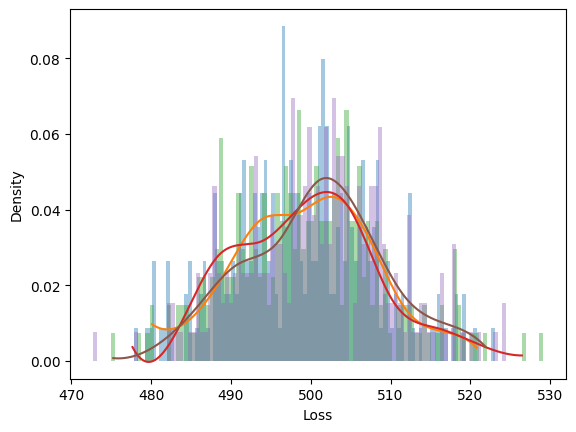

In [55]:
# Monte Carlo loss distribution comparison: linear vs bullet exposures (J=5, N=1000)
num_trials = 250

contract_base = {"P": 100.0, "T": T_horizon, "N": 60, "r": 0.15, "LGD": rng.uniform(0.4, 0.6)}

def make_contracts(contract_type):
    return [{**contract_base, "type": contract_type} for _ in range(Nfirms)]

# Linear exposures
loan_contracts = make_contracts("linear")
losses_linear = run_simulation(J, Nfirms, params, T=T_horizon, num_trials=num_trials)
metrics_linear = compute_metrics(losses_linear, alpha=0.95)

# Bullet exposures
loan_contracts = make_contracts("bullet")
losses_bullet = run_simulation(J, Nfirms, params, T=T_horizon, num_trials=num_trials)
metrics_bullet = compute_metrics(losses_bullet, alpha=0.95)

loan_contracts = make_contracts("french")
losses_french = run_simulation(J, Nfirms, params, T=T_horizon, num_trials=num_trials)
metrics_french = compute_metrics(losses_french, alpha=0.95)

# loss_distribution_plot(losses_baselines,1)
loss_distribution_plot(losses_bullet,1)
loss_distribution_plot(losses_linear,1)
loss_distribution_plot(losses_french,1)

metrics_linear, metrics_bullet, metrics_french


({'Mean': np.float64(500.67810319144064),
  'Std': np.float64(9.639467139156357),
  'VaR': np.float64(517.6171188958954),
  'ES': np.float64(520.5240401338621),
  'ExcessKurtosis': np.float64(0.08326147097274017)},
 {'Mean': np.float64(500.32189964662285),
  'Std': np.float64(8.61625569103254),
  'VaR': np.float64(514.1182816626776),
  'ES': np.float64(517.5345934854009),
  'ExcessKurtosis': np.float64(0.1946344085475431)},
 {'Mean': np.float64(499.54748250047936),
  'Std': np.float64(9.901088237465816),
  'VaR': np.float64(515.4514214548255),
  'ES': np.float64(519.4984187118042),
  'ExcessKurtosis': np.float64(0.08090944725884475)},
 {'Mean': np.float64(500.4205675098244),
  'Std': np.float64(9.270003151115112),
  'VaR': np.float64(515.3987266650555),
  'ES': np.float64(517.9097279778969),
  'ExcessKurtosis': np.float64(-0.05656634793042015)})

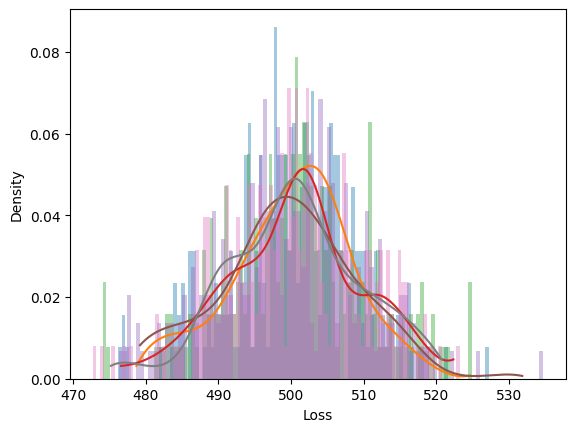

In [58]:
# Monte Carlo loss distribution comparison
num_trials = 250

contract_base = {"P": 100.0, "T": T_horizon, "N": 60, "r": 0.15, "LGD": rng.uniform(0.4, 0.6)}

def make_contracts(contract_type):
    return [{**contract_base, "type": contract_type} for _ in range(Nfirms)]

# Linear exposures
loan_contracts = make_contracts("linear")
losses_linear = run_simulation(J, Nfirms, params, T=T_horizon, num_trials=num_trials)
metrics_linear = compute_metrics(losses_linear, alpha=0.95)

# Bullet exposures
loan_contracts = make_contracts("bullet")
losses_bullet = run_simulation(J, Nfirms, params, T=T_horizon, num_trials=num_trials)
metrics_bullet = compute_metrics(losses_bullet, alpha=0.95)

# French exposures
loan_contracts = make_contracts("french")
losses_french = run_simulation(J, Nfirms, params, T=T_horizon, num_trials=num_trials)
metrics_french = compute_metrics(losses_french, alpha=0.95)

# Borrowing ensues
loan_contracts = make_contracts("negative amortisation")
losses_negam = run_simulation(J, Nfirms, params, T=T_horizon, num_trials=num_trials)
metrics_negam = compute_metrics(losses_negam, alpha=0.95)

# loss_distribution_plot(losses_baselines,1)
loss_distribution_plot(losses_bullet,1)
loss_distribution_plot(losses_linear,1)
loss_distribution_plot(losses_french,1)
loss_distribution_plot(losses_negam,1)

metrics_linear, metrics_bullet, metrics_french, metrics_negam
